In [1]:
from matplotlib.image import imread 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import cv2
import pandas as pd
import glob
import os
import skimage as ski

import warnings
warnings.filterwarnings("ignore")

In [2]:
# ----- Read filtered file -----
def read_reshape(nof):
    image = imread(nof)
    
    
    image.shape
    
    # image is represented in 3d matrix
    # first val is height
    # second val is width'
    # third val is # of color channels (RGBA)
    plt.title("Original image")
    plt.imshow(image)
    
    # -- Reshape image for processing ---
    X = image.reshape(-1,4)
    X.shape
    return X, image

In [3]:
# Create n clusters of colors
def segment(X, image): 
    kmeans = KMeans(n_clusters = num_clusters).fit(X)
    
    # -- Debugging
    # print(kmeans.cluster_centers_)
    # print(kmeans.labels_)
    
    segmented_image = kmeans.cluster_centers_[kmeans.labels_]
    # print(segemented_image)
    
    segmented_image = segmented_image.reshape(image.shape)
    segmented_image_pil = Image.fromarray((segmented_image * 255).astype(np.uint8))
    segmented_image_pil.save(f'./Images/Final/Classified/{date}.png')
    plt.title("Segmented Image")
    plt.imshow(segmented_image)
    return kmeans, segmented_image

In [4]:
def get_colors(kmeans, segmented):
    color = list(kmeans.cluster_centers_[3][:3])
    plt.figure(figsize=(6, 4))
    for i, color in enumerate(list(kmeans.cluster_centers_)):
        plt.subplot(1, num_clusters, i+1)
        plt.title(f"{i}")
        plt.imshow([[color[:3]]])
    
    
    hash = {}
    for index, color in enumerate(list(kmeans.cluster_centers_)):
        hash[index] = list(color)

    
    sorted_hash = sorted(hash.items(), key = lambda x: x[1][0], reverse = False)
    print("Sorted: ", sorted_hash)
    return sorted_hash


In [5]:
# from sklearn.metrics import silhouette_score
#kmeans.inertia_
## Calculate Silhouette score
# silhouette_score(X, kmeans.labels_)

In [6]:
# Determine whether there are unknown regions
def get_water(sorted_hash):
    r1 = sorted_hash[0][1][0]
    g1 = sorted_hash[0][1][1]
    b1 = sorted_hash[0][1][2]
    
    r2 = sorted_hash[1][1][0]
    g2 = sorted_hash[1][1][1]
    b2 = sorted_hash[1][1][2]
    
    unknown = False
    blue = False
    if r1 < 0.03 and g1 < 0.03 and b1 < 0.03:
        print("Unkown region")
        unknown = True
    elif r1 < 0.4:
        print("Blue Region marked")
        blue = True
        
    if unknown and r2 < 0.4:
        print("Blue Region marked")
        blue = True
    
    res = 0
    if unknown and blue:
        res = sorted_hash[2]
    elif unknown or blue:
        res = sorted_hash[1]
    else:
        res = sorted_hash[0]
    
    adjusted = [int(num*255) for num in res[1]]
    print("Water RGB before adjusted: ", res[1])
    print("Adjusted RGB: ", adjusted)
    return adjusted

In [7]:
# - Split the image into respective sections -
def split(date):
    image = Image.open(f"./Images/Final/Classified/{date}.png")
    
    width, height = image.size
    
    # Define the coordinates for the vertical lines
    line1 = width / 4.4
    line2 = width / 2.13
    line3 = width / 1.48
    
    # Split the image into four regions
    region1 = image.crop((35, 0, line1, height))
    region2 = image.crop((line1, 0, line2, height))
    region3 = image.crop((line2, 0, line3, height))
    region4 = image.crop((line3, 0, width, height))
    
    
    plt.subplot(1, 4, 1)
    plt.imshow(region1)
    plt.title("800-950")
    
    plt.subplot(1,4,2)
    plt.imshow(region2)
    plt.title("950-1100")
    
    plt.subplot(1,4,3)
    plt.imshow(region3)
    plt.title("1100-1250")
    
    plt.subplot(1,4,4)
    plt.imshow(region4)
    plt.title("1250-1400")

    li = [region1, region2, region3, region4]
    for i in range(len(li)):
        li[1].save(f'./Images/Final/Bin{i+1}/{date}.png')

    return region1, region2, region3, region4

In [8]:
def get_individual(image, adjusted):
    image_array = np.array(image)
    
    # Reshape the image array to a 1D array of pixels
    pixels = image_array.reshape(-1, image_array.shape[-1])
    
    # Find the unique pixels
    unique_pixels, counts = np.unique(pixels, axis = 0, return_counts = True)
    
    data = {}
    for i, (pixel, num) in enumerate(zip(unique_pixels, counts)):
        r, g, b, a = pixel
        if int(r) == 0 and int(g) == 0 and int(b) == 0:
            print("Unknown spot detected during calculation...removing")
            continue
        else:
            data[tuple(pixel)] = num

    
    
    # adjusted corresponds to the rgb after converting it to 0-255
    if tuple(adjusted) in data:
        water = data[tuple(adjusted)]
    else:
        water = 0 
    total_pixels = sum(data.values())

    if total_pixels != 0: 
        ratio = round(water / total_pixels, 6)
        ratio *= 100
    else:
        ratio = 0
    return ratio

In [10]:
def get_data(date, year, name_of_file, num_clusters):
    out, original = read_reshape(name_of_file)
    kmeans, seg = segment(out, original)
    sorted_colors = get_colors(kmeans, seg)
    water = get_water(sorted_colors)
    reg1, reg2, reg3, reg4 = split(date)
    return water, reg1, reg2, reg3, reg4, seg

In [13]:
data_bin1 = {}
data_bin2 = {}
data_bin3 = {}
data_bin4 = {}
data_no_bin = {}
year = "2020"
num_clusters = 9

files = glob.glob(f"./Images/Final/{year}/*.png")
dates = [date[-12:-4] for date in files]
for date in dates: 
    name_of_file = f"./Images/Final/{year}/{date}.png"
    water, reg1, reg2, reg3, reg4, seg = get_data(date, year, name_of_file, num_clusters)
    li = [reg1, reg2, reg3, reg4]
    hash_li = [data_bin1, data_bin2, data_bin3, data_bin4]
    for i in range(len(li)):
        ratio = get_individual(li[i], water)
        print(f"Bin {i+1}: {ratio} on {date}")
        hash_li[i][date] = ratio
    entire_image = Image.open(f"./Images/Final/Classified/{date}.png")
    ratio_total = get_individual(entire_image, water)
    print(f"Total: {ratio_total} on {date}")
    data_no_bin[date] = ratio_total
    print("\n")
print(dates)


[]


In [11]:
print(data_bin1)
print(data_bin2)
print(data_bin3)
print(data_bin4)


{'20220615': 0.4568, '20220625': 0.4667, '20220708': 0.7687, '20220710': 0.6386000000000001, '20220720': 0.0386, '20220729': 0.3117, '20220813': 0.1437, '20220828': 1.1957}
{'20220615': 0.0065, '20220625': 0.013, '20220708': 0.9762, '20220710': 1.4432, '20220720': 0.7407, '20220729': 0.7773, '20220813': 0.47340000000000004, '20220828': 0.7289}
{'20220615': 0.0, '20220625': 0.0, '20220708': 0.281, '20220710': 0.959, '20220720': 2.5103, '20220729': 3.053, '20220813': 0.46090000000000003, '20220828': 0.5021}
{'20220615': 0.0014, '20220625': 0.0, '20220708': 0, '20220710': 0.3471, '20220720': 1.4369, '20220729': 1.4295, '20220813': 1.2457, '20220828': 0.6204999999999999}


In [12]:
data = {1: data_bin1, 2: data_bin2, 3: data_bin3, 4: data_bin4}

In [13]:
def create_table():
    df = pd.DataFrame(columns = ["Year", "X", "Y", "Type", "Bands", "Bin"])
    dir = "./main.csv"
    if os.path.exists(dir): 
        return
    else:
        print("Creating table...")
        df.to_csv(directory, index = False)

In [14]:
def save_table(obj, year, method, bands, bin):
    create_table()
    new_obj = {"X": obj.keys(),
               "Y": obj.values(),
               "Year": year,
               "Type": method, 
               "Bands": bands,
               "Bin": bin
              }
    df = pd.DataFrame(new_obj)
    temp = df.to_csv("./temp.csv", index = False)
    print("Appending")
    existing_df = pd.read_csv("./main.csv")
    new_df = pd.read_csv("./temp.csv")

    existing_df = pd.concat([existing_df, new_df], ignore_index = True)
    existing_df = existing_df.drop_duplicates()

    existing_df.to_csv("./main.csv", index = False)

In [15]:
for i in range(len(data)):
    save_table(data[i+1], year, "Kmeans", "1,2,3,4", i+1)

Appending
Appending
Appending
Appending


In [33]:
save_table(data_no_bin, year, "Kmeans", "1,2,3,4", -1)

Appending


In [32]:
print(data_no_bin)

{'20220615': 0.051500000000000004, '20220625': 0.9017000000000001, '20220708': 0.8336, '20220710': 0.8182999999999999, '20220720': 1.2331, '20220729': 1.5003, '20220813': 0.6504, '20220828': 0.6834}


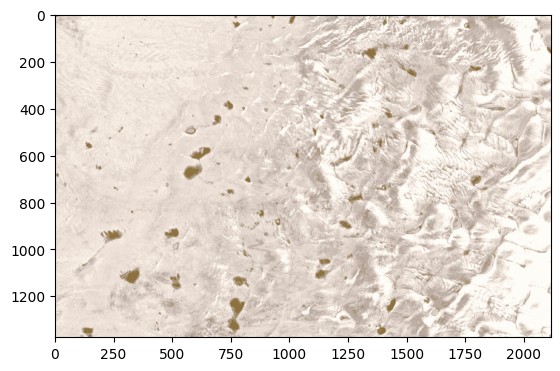

In [49]:
image = Image.open("./Images/Final/Classified/20220710.png")


image_array = np.array(image)


image_rgb = image_array[:, :, :3]


target_color = np.array([141, 113, 63])


mask = np.all(image_rgb == target_color, axis=-1)


filtered_image_array = np.zeros_like(image_array)
filtered_image_array[mask] = image_array[mask]


filtered_image = Image.fromarray(filtered_image_array)


filtered_image.show()
plt.imshow(image)

In [39]:
rgb_color = (141, 113, 63)

# Create a NumPy array filled with the specified color
color_image = np.full((300, 300, 3), rgb_color, dtype=np.uint8)

# Display the color image
cv2.imshow("Color Image", color_image)
cv2.waitKey(0)
cv2.destroyAllWindows()